In [1]:
from cmdstanpy import CmdStanModel 
import arviz as az
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import stan
import seaborn as sns
import plotly.express as px

plt.style.use("ggplot")  #using style ggplot

/usr/local/anaconda3/envs/DataAnalytics/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('./cars.csv')
data.head(10)

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
0,0,opel,combo,gen-d-2011,2015,139568,1248,Diesel,Janki,Mazowieckie,35900
1,1,opel,combo,gen-d-2011,2018,31991,1499,Diesel,Katowice,Śląskie,78501
2,2,opel,combo,gen-d-2011,2015,278437,1598,Diesel,Brzeg,Opolskie,27000
3,3,opel,combo,gen-d-2011,2016,47600,1248,Diesel,Korfantów,Opolskie,30800
4,4,opel,combo,gen-d-2011,2014,103000,1400,CNG,Tarnowskie Góry,Śląskie,35900
5,5,opel,combo,gen-d-2011,2017,121203,1598,Diesel,Warszawa,Mazowieckie,51900
6,6,opel,combo,gen-d-2011,2017,119965,1248,Diesel,Wrocław,Dolnośląskie,44700
7,7,opel,combo,gen-d-2011,2016,201658,1248,Diesel,Lublin,Lubelskie,29000
8,8,opel,combo,gen-d-2011,2014,178666,1598,Diesel,Złotów,Wielkopolskie,28900
9,9,opel,combo,gen-d-2011,2015,113000,1248,Diesel,Strzyżew,Mazowieckie,34900


In [3]:
print(data.mark.unique())

['opel' 'audi' 'bmw' 'volkswagen' 'ford' 'mercedes-benz' 'renault'
 'toyota' 'skoda' 'alfa-romeo' 'chevrolet' 'citroen' 'fiat' 'honda'
 'hyundai' 'kia' 'mazda' 'mini' 'mitsubishi' 'nissan' 'peugeot' 'seat'
 'volvo']


In [4]:
print(data.loc[(data['mark'] == 'bmw') | (data['mark'] == 'mercedes-benz') | 
               (data['mark'] == 'audi')].model.unique())

['a3' '80' 'a1' 'a2' 'a4' 'a4-allroad' 'a5' 'a6' 'a6-allroad' 'a7' 'a8'
 'e-tron' 'q2' 'q3' 'q4-sportback' 'q5' 'q7' 'q8' 'rs3' 'rs5' 'rs6'
 'rs-q3' 's3' 's5' 's8' 'sq5' 'tt' '3gt' '5gt' 'i3' 'm2' 'm3' 'm4' 'm5'
 'm8' 'seria-1' 'seria-2' 'seria-3' 'seria-4' 'seria-5' 'seria-6'
 'seria-7' 'seria-8' 'x1' 'x2' 'x3' 'x4' 'x5' 'x5-m' 'x6' 'x6-m' 'x7'
 'amg-gt' 'citan' 'cl-klasa' 'cla-klasa' 'clk-klasa' 'cls-klasa'
 'gl-klasa' 'gla-klasa' 'glb-klasa' 'glc-klasa' 'gle-klasa' 'glk-klasa'
 'gls-klasa' 'a-klasa' 'b-klasa' 'c-klasa' 'e-klasa' 'g-klasa' 'r-klasa'
 's-klasa' 'v-klasa' 'm-klasa' 'sl' 'slk-klasa' 'sprinter' 'viano' 'vito']


In [5]:
segments = {
    "A": ['i3', 'cla-klasa'],
    "B": ['a1', 'a2', 'q2', 'a-klasa'],
    "C": ['seria-1', 'seria-2', 'm2', 'a3', 'a4', 'rs-q3', 's3', 'citan', 'gla-klasa', 'b-klasa'],
    "D": ['seria-3', 'seria-4', 'm4', 'm3', '3gt', '80', 'a4-allroad', 'a5', 'q4-sportback', 'q5', 's5',
          'glb-klasa', 'glc-klasa', 'glk-klasa', 'sl'],
    "E": ['seria-5', 'seria-8', 'm8', 'm5', '5gt', 'x6', 'x6-m', 'x5-m', 'a6', 'a6-allroad', 'e-tron', 'q7',
          'q8', 's8', 'gle-klasa', 'e-klasa', 'g-klasa', 'r-klasa'],
    "F": ['seria-7', 'x7', 'a7', 'a8', 'cl-klasa', 'gl-klasa', 'gls-klasa', 's-klasa'],
    "G": ['seria-6', 'rs6', 'clk-klasa', 'cls-klasa', 'slk-klasa'],
    "I": ['x1', 'x2', 'x3', 'x4', 'x5', 'q3', 'm-klasa'],
    "S": ['amg-gt'],
    "Unknown": ['rs3', 'rs5', 'sq5', 'tt', 'c-klasa', 'v-klasa', 'sprinter', 'viano', 'vito']
}
segments_invert = {}
for key, value in segments.items():
    for val in value:
        segments_invert[str(val)] = key
segments_invert

{'i3': 'A',
 'cla-klasa': 'A',
 'a1': 'B',
 'a2': 'B',
 'q2': 'B',
 'a-klasa': 'B',
 'seria-1': 'C',
 'seria-2': 'C',
 'm2': 'C',
 'a3': 'C',
 'a4': 'C',
 'rs-q3': 'C',
 's3': 'C',
 'citan': 'C',
 'gla-klasa': 'C',
 'b-klasa': 'C',
 'seria-3': 'D',
 'seria-4': 'D',
 'm4': 'D',
 'm3': 'D',
 '3gt': 'D',
 '80': 'D',
 'a4-allroad': 'D',
 'a5': 'D',
 'q4-sportback': 'D',
 'q5': 'D',
 's5': 'D',
 'glb-klasa': 'D',
 'glc-klasa': 'D',
 'glk-klasa': 'D',
 'sl': 'D',
 'seria-5': 'E',
 'seria-8': 'E',
 'm8': 'E',
 'm5': 'E',
 '5gt': 'E',
 'x6': 'E',
 'x6-m': 'E',
 'x5-m': 'E',
 'a6': 'E',
 'a6-allroad': 'E',
 'e-tron': 'E',
 'q7': 'E',
 'q8': 'E',
 's8': 'E',
 'gle-klasa': 'E',
 'e-klasa': 'E',
 'g-klasa': 'E',
 'r-klasa': 'E',
 'seria-7': 'F',
 'x7': 'F',
 'a7': 'F',
 'a8': 'F',
 'cl-klasa': 'F',
 'gl-klasa': 'F',
 'gls-klasa': 'F',
 's-klasa': 'F',
 'seria-6': 'G',
 'rs6': 'G',
 'clk-klasa': 'G',
 'cls-klasa': 'G',
 'slk-klasa': 'G',
 'x1': 'I',
 'x2': 'I',
 'x3': 'I',
 'x4': 'I',
 'x5': 'I',
 

In [6]:
data = data.loc[(data['mark'] == 'bmw') | (data['mark'] == 'mercedes-benz') | 
               (data['mark'] == 'audi')]
data

,Unnamed: 0,mark,model,generation_name,year,mileage,vol_engine,fuel,city,province,price
8061,8061,audi,a3,gen-8p-2003-2012,2010,169500,1390,Gasoline,Cieszyn,Śląskie,29900
8062,8062,audi,a3,gen-8p-2003-2012,2018,67990,1500,Gasoline,Kielce,Świętokrzyskie,129850
8063,8063,audi,a3,gen-8p-2003-2012,2008,222248,1896,Diesel,Częstochowa,Śląskie,22900
8064,8064,audi,a3,gen-8p-2003-2012,2010,243000,1968,Diesel,Zawiercie,Śląskie,27907
8065,8065,audi,a3,gen-8p-2003-2012,2009,259658,1598,Diesel,Nowy Dwór Gdański,Pomorskie,23900
...,...,...,...,...,...,...,...,...,...,...,...
62658,62658,mercedes-benz,vito,gen-w639-2003,2007,266860,2148,Diesel,Stalowa Wola,Podkarpackie,27999
62659,62659,mercedes-benz,vito,gen-w639-2003,2013,270000,2987,Diesel,Olsztyn,Warmińsko-mazurskie,64900
62660,62660,mercedes-benz,vito,gen-w639-2003,2005,342600,2200,Diesel,Piotrkowice,Świętokrzyskie,14500
62661,62661,mercedes-benz,vito,gen-w639-2003,2006,282000,2148,Diesel,Świnoujście,Zachodniopomorskie,12500


In [7]:
#checking null value 
data.isna().sum()


Unnamed: 0            0
mark                  0
model                 0
generation_name    4960
year                  0
mileage               0
vol_engine            0
fuel                  0
city                  0
province              0
price                 0
dtype: int64

In [8]:
data.drop(columns = ["generation_name", 'Unnamed: 0', 'city', 'province'],inplace=True) #dropping 

#checking null value 
data.isna().sum()

mark          0
model         0
year          0
mileage       0
vol_engine    0
fuel          0
price         0
dtype: int64

In [9]:
data['model_types'] = data['model'].replace(segments_invert)
data

,mark,model,year,mileage,vol_engine,fuel,price,model_types
8061,audi,a3,2010,169500,1390,Gasoline,29900,C
8062,audi,a3,2018,67990,1500,Gasoline,129850,C
8063,audi,a3,2008,222248,1896,Diesel,22900,C
8064,audi,a3,2010,243000,1968,Diesel,27907,C
8065,audi,a3,2009,259658,1598,Diesel,23900,C
...,...,...,...,...,...,...,...,...
62658,mercedes-benz,vito,2007,266860,2148,Diesel,27999,Unknown
62659,mercedes-benz,vito,2013,270000,2987,Diesel,64900,Unknown
62660,mercedes-benz,vito,2005,342600,2200,Diesel,14500,Unknown
62661,mercedes-benz,vito,2006,282000,2148,Diesel,12500,Unknown


In [10]:
print(data.model_types.unique())

['C' 'D' 'B' 'E' 'F' 'I' 'Unknown' 'G' 'A' 'S']


/usr/local/anaconda3/envs/DataAnalytics/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


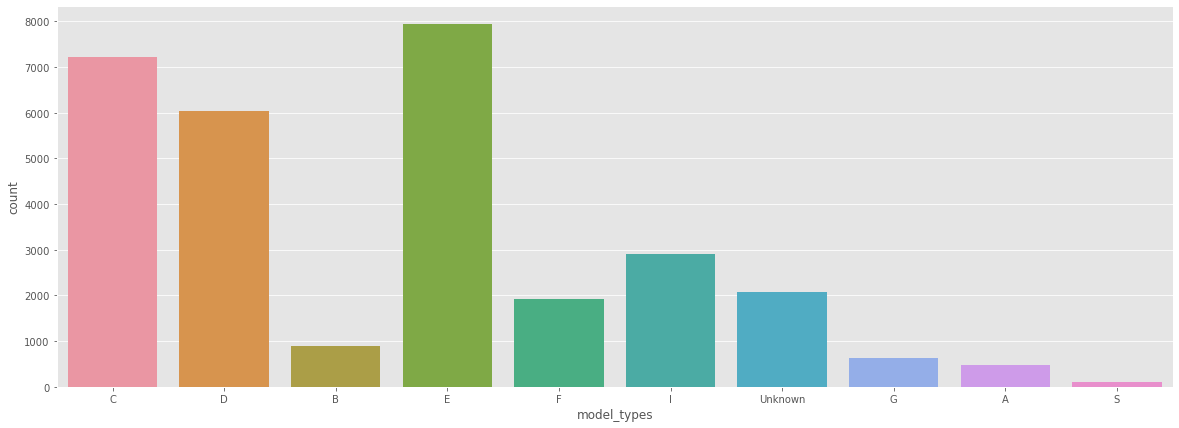

In [11]:
# how much repeat type models  in the dataset

plt.figure(figsize=(20,7))
sns.countplot(data["model_types"])
plt.show()

In [16]:
data['car_age'] = 2022 - data['year']
data=data.loc[(data['car_age']>2)]

In [17]:
data = data.loc[(data['model_types'] == 'F')]


In [19]:
# Standarizing mileage, car_age and price
# mileage
mean_mileage = data.mileage.mean()
std_mileage = data.mileage.std()
data['c_mileage'] = data.mileage - mean_mileage
data['s_mileage'] = (data.mileage - mean_mileage)/std_mileage

# car_age
mean_car_age = data.car_age.mean()
std_car_age = data.car_age.std()
data['c_car_age'] = data.car_age - mean_car_age
data['s_car_age'] = (data.car_age - mean_car_age)/std_car_age

# price
mean_price = data.price.mean()
std_price = data.price.std()
data['s_price'] = (data.price - mean_price)/std_price
data.head(10)


,mark,model,year,mileage,vol_engine,fuel,price,model_types,car_age,c_mileage,s_mileage,c_car_age,s_car_age,s_price
20650,audi,a7,2011,190000,3000,Gasoline,107700,F,11,14580.49846,0.148886,-0.279729,-0.045981,-0.298736
20651,audi,a7,2012,189400,2967,Diesel,67000,F,10,13980.49846,0.142760,-1.279729,-0.210360,-0.564184
20652,audi,a7,2010,250000,2967,Diesel,60000,F,12,74580.49846,0.761567,0.720271,0.118397,-0.609839
20653,audi,a7,2016,84000,2995,Gasoline,116000,F,6,-91419.50154,-0.933516,-5.279729,-0.867874,-0.244603
20654,audi,a7,2017,90000,2995,Gasoline,149999,F,5,-85419.50154,-0.872248,-6.279729,-1.032252,-0.022859
20655,audi,a7,2013,109967,2967,Diesel,125000,F,9,-65452.50154,-0.668358,-2.279729,-0.374738,-0.185904
20656,audi,a7,2013,82575,2773,Gasoline,100000,F,9,-92844.50154,-0.948067,-2.279729,-0.374738,-0.348956
20657,audi,a7,2017,75000,2967,Diesel,199000,F,5,-100419.50154,-1.025418,-6.279729,-1.032252,0.296729
20658,audi,a7,2012,214000,2967,Diesel,88400,F,10,38580.49846,0.393959,-1.279729,-0.210360,-0.424612
20659,audi,a7,2016,98000,1984,Gasoline,165900,F,6,-77419.50154,-0.790557,-5.279729,-0.867874,0.080848


In [20]:
def is_sorted(a):
    '''Check if numpy 1d-array is sorted '''
    if type(a) != np.ndarray:
        raise TypeError('Argument must be a numpy array but is {}'.format(type(a))) 
    if len(a.shape) > 1:
        raise ValueError('Array must be 1 dimensional but has shape {}'.format(a.shape)) 
    return np.all(a[:-1] <= a[1:])

In [21]:
LIGHT="#FFFCDC"
LIGHT_HIGHLIGHT="#FEF590"
MID="#FDED2A"
MID_HIGHLIGHT="#F0DC05"
DARK="#EECA02"
DARK_HIGHLIGHT="#BB9700"
GREEN="#00FF00"
LIGHT_GREY="#DDDDDD"


In [22]:
def sort_1d_array_and_2d_array_by_1d_array(x, fx):
    if (type(x) != np.ndarray) or (type(fx) != np.ndarray):
        raise TypeError('At least one of the arguments is not a numpy array type(x)={}, type(fx)={}',format(type(x), type(fx)))
    if len(x)!=fx.shape[1]:
        raise ValueError('2d array number of columns is not matching the 1d array. Expected {} got {}'.format(len(x),fx.shape[1]))
    arr2D = np.concatenate([np.expand_dims(x,axis=0),fx],axis=0) 
    sortedArr = arr2D [ :, arr2D[0].argsort()]
    return sortedArr[0,:], sortedArr[1:,:]

In [23]:
def get_quantiles(fx, probs=None): 
    if probs is None:
        probs = [10, 20, 30, 40, 50, 60, 70, 80, 90] 
    if len(probs) % 2 == 0:
        raise ValueError('Number of quantiles must be even') 
    if len(probs) > 11:
        raise ValueError('Too many quantiles (max is 11)') 
    if probs[int(len(probs)/2)] != 50:
        raise ValueError('Middle quantile should be 50 but is {}'.format(probs(int(len(probs)/2)))) 
    return np.percentile(fx, probs, axis=0)

In [24]:
def ribbon_plot(x, fx, ax=None,zorder=0,probs=None,supress_warning=False):
    '''Plot a ribbon plot for regression and similar.
    Plot consists of quantiles (by 10%) of a variate (fx) as a function of covariate (x). x has shape (n, )
    fx has shape (N,n)
    '''
    if ax is None:
        ax = plt.gca() 
    if not is_sorted(x):
        x, fx = sort_1d_array_and_2d_array_by_1d_array(x, fx) 
    if (len(set(x)) != len(x)) and (not supress_warning):
        warnings.warn("x variable has repeated values, which can influence the plot")
    perc_interv = get_quantiles(fx, probs)
    nq=perc_interv.shape[0]
    colortab = [LIGHT,LIGHT_HIGHLIGHT,MID,MID_HIGHLIGHT,DARK,DARK_HIGHLIGHT]
    
    for i in range(int(nq/2)): ax.fill_between(x,
                            perc_interv[i,:],
                            perc_interv[-(i+1),:],
                            color=colortab[i],
                            zorder=zorder)
    ax.plot(x,perc_interv[int(nq/2),:],color=colortab[int(nq/2)],zorder=zorder) 
    return ax

In [41]:
print("Standard diviation of mileage:",data.s_mileage.std())
print("Mean of mileage:",data.s_mileage.mean())
print("Standard diviation of price:",data.s_price.std())
print("Mean of price:",data.s_price.mean())
print("Max value of price:",data.s_price.max())
print("Maximal value of mileage:",data.s_mileage.max())
print("Maximal value of year:",data.s_car_age.max())

Standard diviation of mileage: 1.0
Mean of mileage: 3.502367151004807e-17
Standard diviation of price: 1.0
Mean of price: -7.004734302009614e-17
Max value of price: 14.65114792583687
Maximal value of mileage: 5.560897178995661
Maximal value of year: 3.241587436917497


Centered car mileage min:  -175398.50154035736
Centered car mileage max:  544580.4984596426


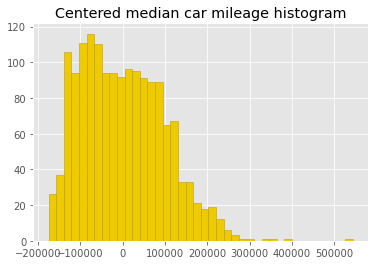

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plt.hist(data.c_mileage, bins = 40, color = DARK, edgecolor = DARK_HIGHLIGHT)
axes.set_title("Centered median car mileage histogram")
plt.plot()
print("Centered car mileage min: ", data.c_mileage.min())
print("Centered car mileage max: ", data.c_mileage.max())

Text(0.5, 1.0, 'Price histogram')

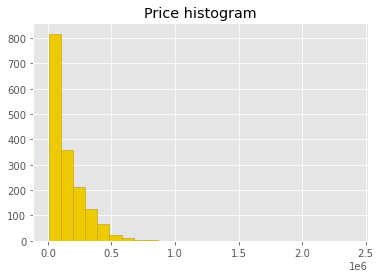

In [27]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plt.hist(data.price, bins = 25, color = DARK, edgecolor = DARK_HIGHLIGHT)
axes.set_title("Price histogram")

[]

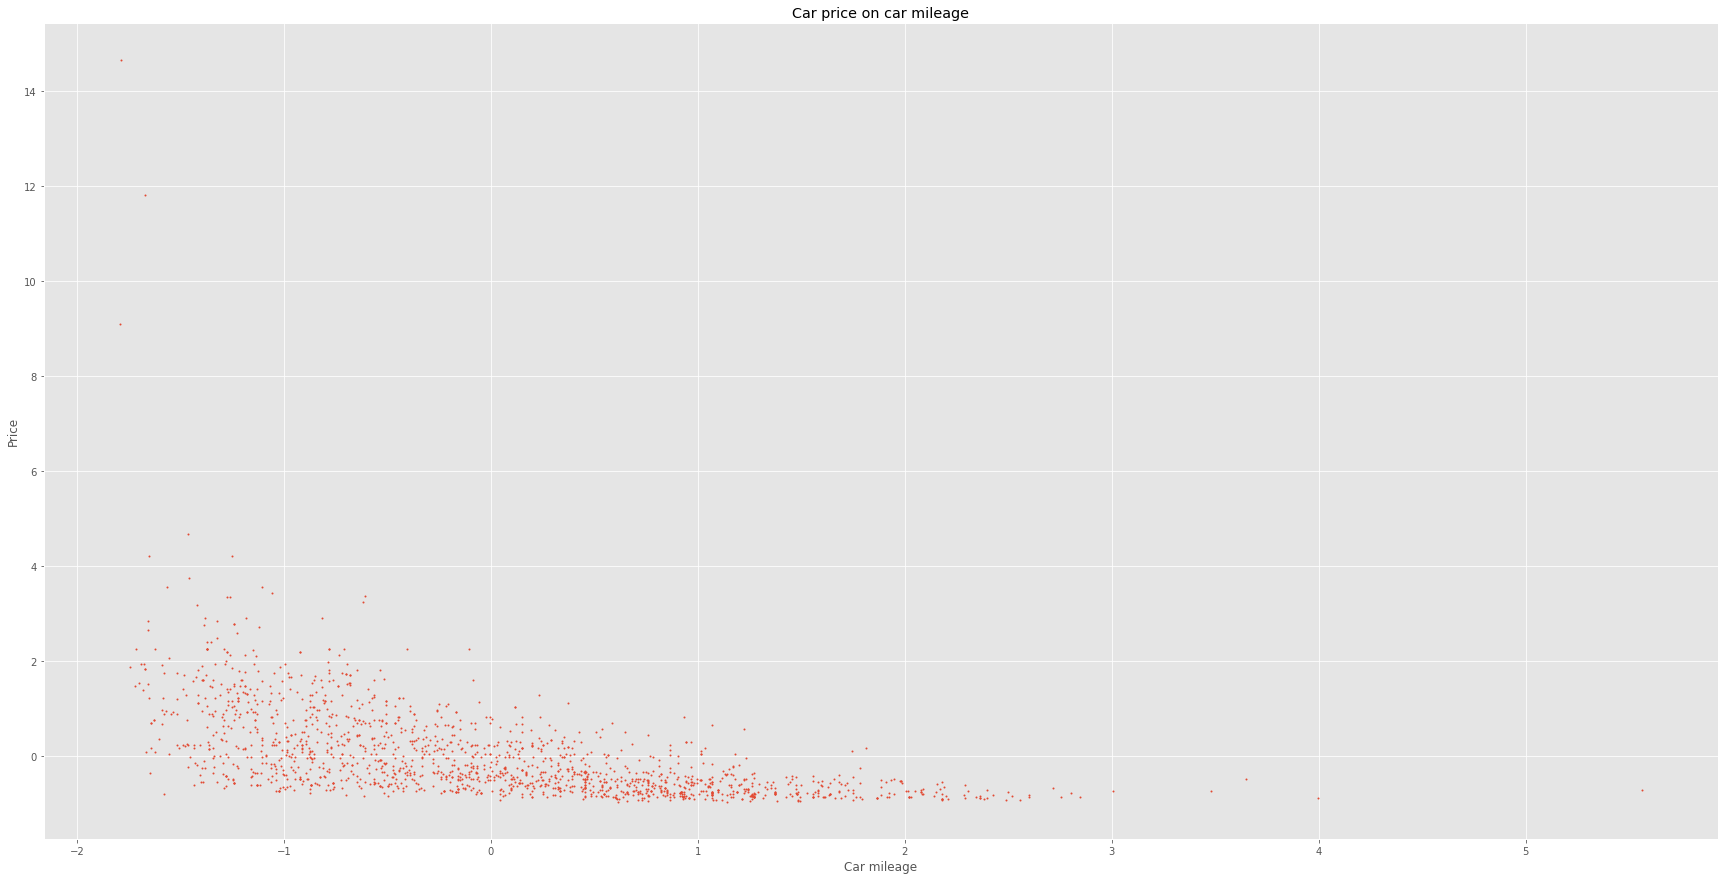

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(30, 15))
plt.plot(data.s_mileage, data.s_price, 'o', markersize=1)
axes.set_xlabel("Car mileage")
axes.set_ylabel("Price")
axes.set_title("Car price on car mileage")
plt.plot()

In [29]:
with open('one_param_ppc_mileage.stan', 'r') as file: 
    print(file.read())

data { 
    int N;
    real mileage[N];
}

generated quantities {
            real alpha = normal_rng(0,1);
            real beta = normal_rng(0,1);
            real sigma = exponential_rng(0.01);
            real price[N];
            for (i in 1:N) {
                price[i] = normal_rng(mileage[i]*beta+alpha,sigma);
            }
}



In [30]:
model1_ppc=CmdStanModel(stan_file='one_param_ppc_mileage.stan')
R = 1000
data_sim={'N': 50, 'mileage': np.linspace(data.s_mileage.min(),data.s_mileage.max())}
sim_one_param=model1_ppc.sample(data=data_sim,
                                iter_sampling=R, 
                                iter_warmup=0, 
                                chains=1,
                                fixed_param=True, 
                                seed=29042020)

alpha_sim=sim_one_param.stan_variable('alpha')
beta_sim=sim_one_param.stan_variable('beta')

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |█████████████████████████████████████████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


[]

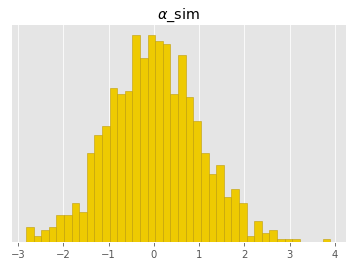

In [31]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
ax = axes 
ax.hist(alpha_sim, bins=40, color=DARK, edgecolor=DARK_HIGHLIGHT, density=True) 
ax.set_title(r'$\alpha$_sim')
ax.set_yticks(())

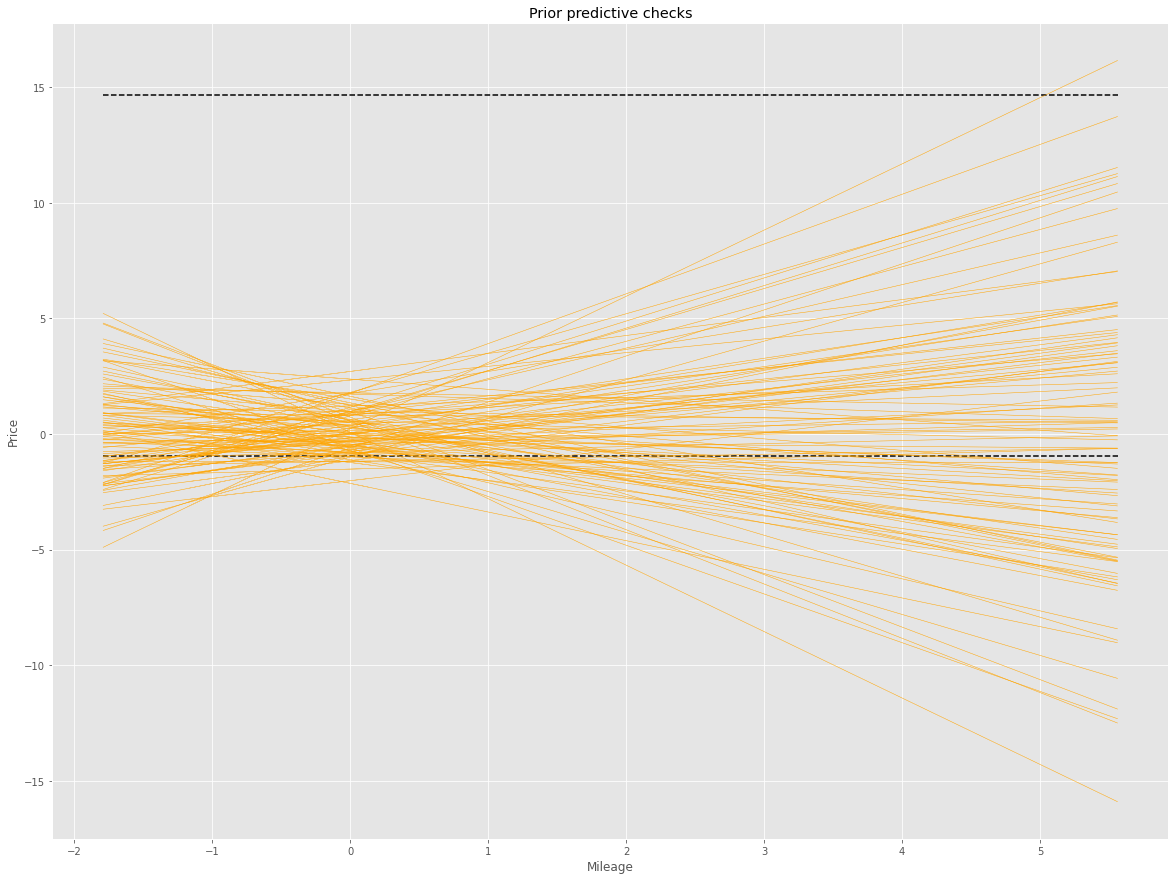

In [32]:
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
axes.hlines([data.s_price.min(), data.s_price.max()], xmin=data.s_mileage.min(),xmax=data.s_mileage.max(),linestyle='--',color='black')

for i in range(100):
    axes.plot(data.s_mileage, alpha_sim[i]+beta_sim[i]*data.s_mileage,color='orange',alpha=0.5,linewidth=0.5)
axes.set_xlabel('Mileage')
axes.set_ylabel('Price')
axes.set_title(r'Prior predictive checks')
plt.show()

### Time to improve first predictor

In [105]:
with open('one_param_ppc_mileage_improved.stan', 'r') as file: 
    print(file.read())

data { 
    int N;
    real mileage[N];
}

generated quantities {
            real alpha = normal_rng(2,2);
            real beta = normal_rng(-0.5,0.5);
            real <lower = 0> sigma = exponential_rng(0.3); 
            real price[N];
            for (i in 1:N) {
                price[i] = normal_rng(mileage[i]*beta+alpha,sigma);
            }
}




In [106]:
model1_improved_ppc=CmdStanModel(stan_file='one_param_ppc_mileage_improved.stan')
R = 1000
data_sim={'N': 50, 'mileage': np.linspace(data.s_mileage.min(),data.s_mileage.max())}
sim2=model1_improved_ppc.sample(data=data_sim,
                                iter_sampling=R, 
                                iter_warmup=0, 
                                chains=1,
                                fixed_param=True, 
                                seed=29042020)

alpha_sim_improved=sim2.stan_variable('alpha')
beta_sim_improved=sim2.stan_variable('beta')

INFO:cmdstanpy:compiling stan file /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/one_param_ppc_mileage_improved.stan to exe file /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/one_param_ppc_mileage_improved
INFO:cmdstanpy:compiled model executable: /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/one_param_ppc_mileage_improved
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/one_param_ppc_mileage_improved.hpp /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/one_param_ppc_mileage_improved.stan
Warning in '/Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/one_param_ppc_mileage_improved.stan', line 3, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/Users/ka


INFO:cmdstanpy:CmdStan done processing.


[]

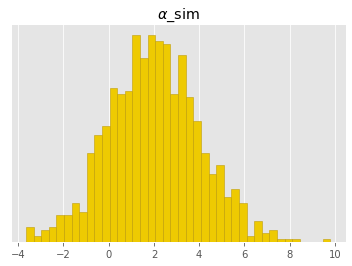

In [107]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
ax = axes 
ax.hist(alpha_sim_improved, bins=40, color=DARK, edgecolor=DARK_HIGHLIGHT, density=True) 
ax.set_title(r'$\alpha$_sim')
ax.set_yticks(())

[]

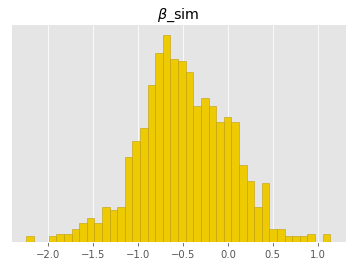

In [108]:
fig, axes = plt.subplots(1, 1, figsize=(6, 4))
ax = axes 
ax.hist(beta_sim_improved, bins=40, color=DARK, edgecolor=DARK_HIGHLIGHT, density=True) 
ax.set_title(r'$\beta$_sim')
ax.set_yticks(())

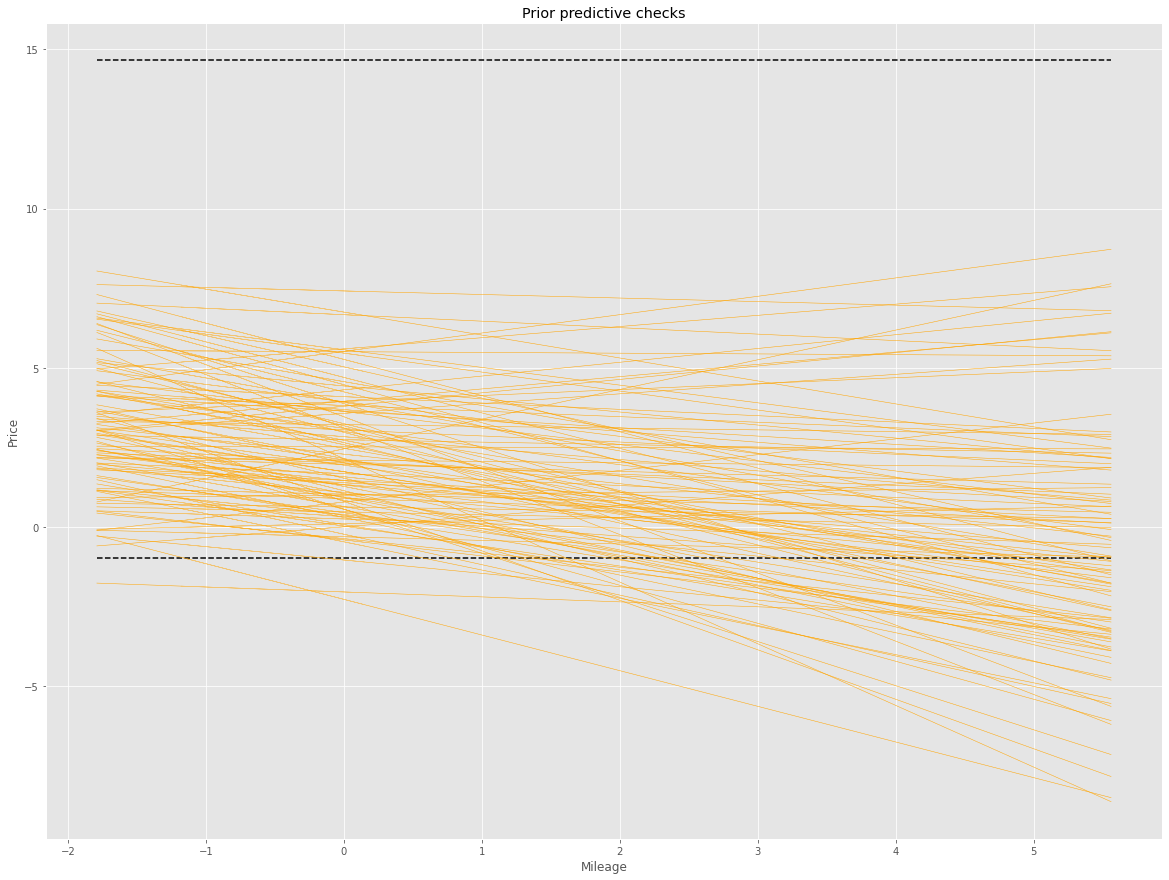

In [109]:
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
axes.hlines([data.s_price.min(), data.s_price.max()], xmin=data.s_mileage.min(),xmax=data.s_mileage.max(),linestyle='--',color='black')

for i in range(100):
    axes.plot(data.s_mileage, alpha_sim_improved[i]+beta_sim_improved[i]*data.s_mileage,color='orange',alpha=0.5,linewidth=0.5)
axes.set_xlabel('Mileage')
axes.set_ylabel('Price')
axes.set_title(r'Prior predictive checks')
plt.show()

In [110]:
az.summary(sim2,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')


,mean,sd,hdi_3%,hdi_97%
alpha,2.01,2.01,-1.47,5.98
beta,-0.49,0.50,-1.39,0.48
sigma,3.29,3.24,0.00,9.39


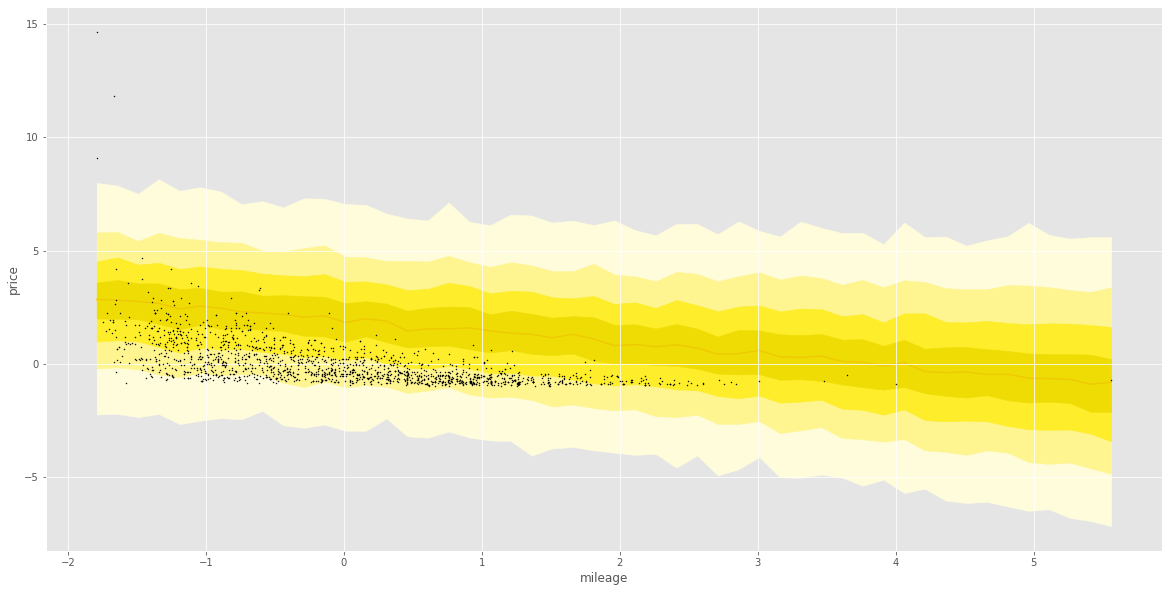

In [111]:
price_sim2=sim2.stan_variable('price')
fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes=ribbon_plot(data_sim['mileage'], price_sim2, axes)
axes.scatter(data.s_mileage, data.s_price, color='black', alpha=0.9, s=1)
axes.set_xlabel('mileage')
axes.set_ylabel('price')
plt.show()

### SECOND PREDICTOR 

In [70]:
with open('one_param_ppc_age.stan', 'r') as file: 
    print(file.read())

data { 
       int N;
       real car_age[N];
}

generated quantities {
            real alpha = normal_rng(1,1.5);
            real beta_car_age = -lognormal_rng(-1.5,1);
            real <lower = 0> sigma = exponential_rng(0.3); 
            real price[N];
            for (i in 1:N) {
                price[i] = normal_rng(car_age[i]*beta_car_age+alpha,sigma);
            }
}





In [71]:
model2_ppc=CmdStanModel(stan_file='one_param_ppc_age.stan')
R = 1000
data_sim2={'N': 50, 'car_age': np.linspace(data.s_car_age.min(),data.s_car_age.max())}
sim3=model2_ppc.sample(data=data_sim2,
                       iter_sampling=R, 
                       iter_warmup=0, 
                       chains=1,
                       fixed_param=True, 
                       seed=29042020)

alpha_sim3=sim3.stan_variable('alpha')
beta_sim3=sim3.stan_variable('beta_car_age')


INFO:cmdstanpy:compiling stan file /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/one_param_ppc_age.stan to exe file /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/one_param_ppc_age
INFO:cmdstanpy:compiled model executable: /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/one_param_ppc_age
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/one_param_ppc_age.hpp /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/one_param_ppc_age.stan
Warning in '/Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/one_param_ppc_age.stan', line 3, column 7: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/one_param_ppc_age.stan', line


INFO:cmdstanpy:CmdStan done processing.


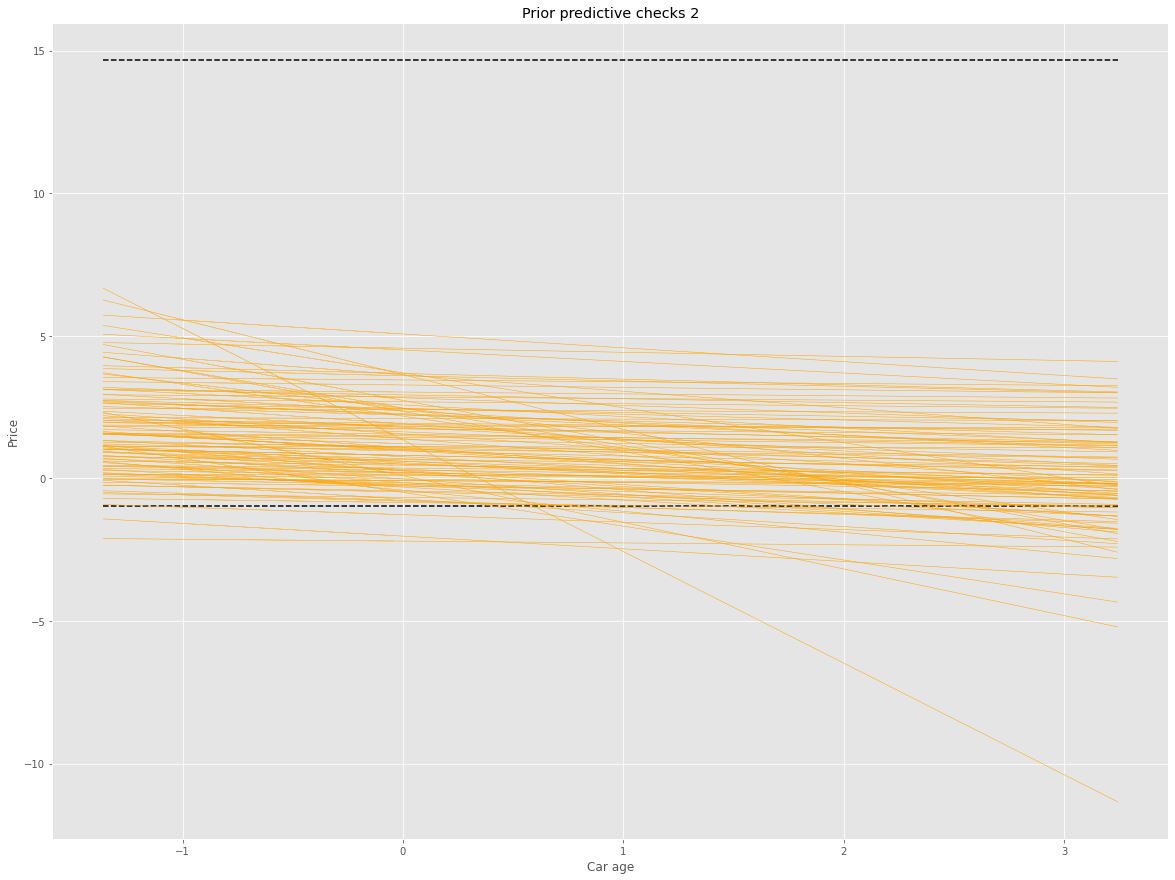

In [72]:
fig, axes = plt.subplots(1, 1, figsize=(20, 15))
axes.hlines([data.s_price.min(), data.s_price.max()], xmin=data.s_car_age.min(),xmax=data.s_car_age.max(),linestyle='--',color='black')
for i in range(100):
    axes.plot(data.s_car_age, alpha_sim3[i]+beta_sim3[i]*data.s_car_age,color='orange',alpha=0.5,linewidth=0.5)
axes.set_xlabel('Car age')
axes.set_ylabel('Price')
axes.set_title(r'Prior predictive checks 2')
plt.show()

In [73]:
az.summary(sim3,var_names=['alpha','beta_car_age','sigma'],round_to=2,kind='stats')

,mean,sd,hdi_3%,hdi_97%
alpha,1.01,1.51,-1.60,3.98
beta_car_age,-0.38,0.51,-1.05,-0.01
sigma,3.29,3.24,0.00,9.39


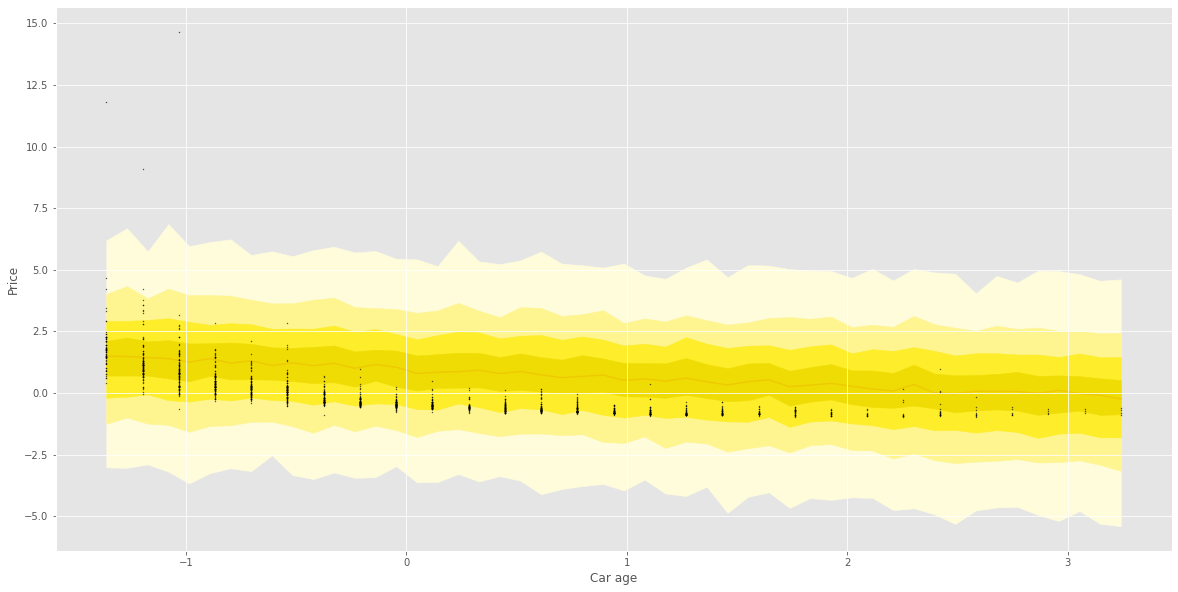

In [74]:
price_sim=sim3.stan_variable('price')
fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes=ribbon_plot(data_sim2['car_age'], price_sim, axes)
axes.scatter(data.s_car_age, data.s_price, color='black', alpha=0.5, s=1)
axes.set_xlabel('Car age')
axes.set_ylabel('Price')
plt.show()

### FIRST MODEL

In [112]:
with open('price_fit.stan', 'r') as file: 
    print(file.read())

data { 
    int N;
    vector[N] mileage;
    real price[N];
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
          
transformed parameters {
    vector[N] mu = mileage*beta+alpha;
}

model {
    alpha ~ normal(2,2);
    beta ~ normal(-0.5,0.5);
    sigma ~ exponential(0.3);
    price ~ normal(mu,sigma);
}

generated quantities {
    real prices[N];
    real log_lik[N];
    for (i in 1:N) {
        prices[i] = normal_rng(mu[i],sigma);
        log_lik[i] = normal_lpdf(price[i] | mu[i], sigma);
    }
}


In [113]:
model1_fit=CmdStanModel(stan_file='price_fit.stan') 
model1_fit.compile(force=False)
d_short=data.head(1000)
data_fit1=dict(N=len(d_short),
              mileage=d_short.s_mileage.values,
              price=d_short.s_price.values)
fit1=model1_fit.sample(data=data_fit1,seed=28052020)
alpha_fit=fit1.stan_variable('alpha')
beta_fit=fit1.stan_variable('beta')
mu_fit=fit1.stan_variable('mu')
price_pred=fit1.stan_variable('prices')
log_lik=fit1.stan_variable('log_lik')
az.summary(fit1,var_names=['alpha','beta','sigma'],round_to=2,kind='stats')

INFO:cmdstanpy:compiling stan file /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/price_fit.stan to exe file /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/price_fit
INFO:cmdstanpy:compiled model executable: /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/price_fit
--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/price_fit.hpp /Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/price_fit.stan
Warning in '/Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/price_fit.stan', line 4, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/Users/kamilbaradziej/PythonProjects/ModellingofCarPrices/price_fit.stan', line 25, column 4: Declaration
    of arrays by placing brac


INFO:cmdstanpy:CmdStan done processing.


,mean,sd,hdi_3%,hdi_97%
alpha,-0.16,0.02,-0.19,-0.13
beta,-0.45,0.02,-0.49,-0.42
sigma,0.52,0.01,0.50,0.54


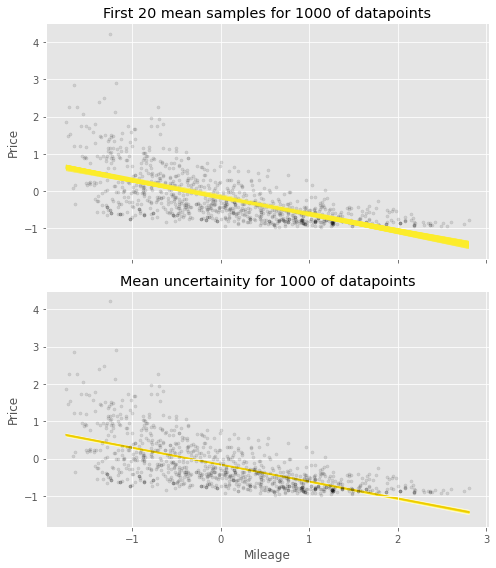

In [117]:
fig, axes = plt.subplots(2,1, figsize=(7, 8),sharey=True,sharex=True) 
ax0=axes[0]
for i in range(100):
    ax0.plot(d_short.s_mileage,
             alpha_fit[i]+beta_fit[i]*d_short.s_mileage,
             color=MID,
             alpha=0.5, 
             linewidth=0.5) 
ax0.scatter(d_short.s_mileage, d_short.s_price, color='black', alpha=0.1, s=10) 
ax0.set_title('First 20 mean samples for {} of datapoints'.format(len(d_short))) 
ax0.set_ylabel('Price')
ax1=axes[1]
ax1=ribbon_plot(d_short.s_mileage.values, mu_fit, ax1, supress_warning=True) 
ax1.scatter(d_short.s_mileage, d_short.s_price, color='black', alpha=0.1, s=10) 
ax1.set_xlabel('Mileage')
ax1.set_ylabel('Price')
ax1.set_title('Mean uncertainity for {} of datapoints'.format(len(d_short))) 
fig.tight_layout()
plt.show()

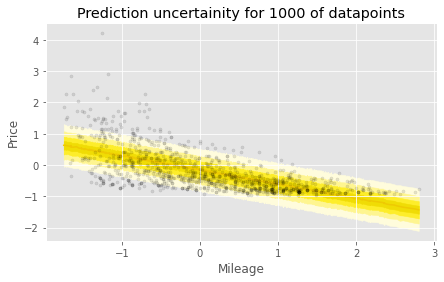

In [115]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))
axes = ribbon_plot(d_short.s_mileage.values, price_pred, axes, supress_warning=True) 
axes.scatter(d_short.s_mileage, d_short.s_price, color='black', alpha=0.1, s=10) 
axes.set_xlabel('Mileage')
axes.set_ylabel('Price')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(d_short))) 
plt.show()

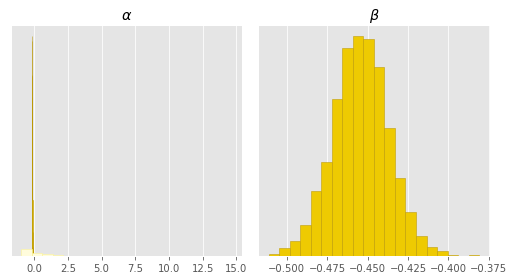

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
ax = axes[0] 
ax.hist(alpha_fit, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT, density=True) 
ax.hist(data.s_price, bins=20, color=LIGHT, edgecolor=LIGHT_HIGHLIGHT, density=True) 
ax.set_title(r'$\alpha$')
ax.set_yticks(())
ax2 = axes[1] 
ax2.hist(beta_fit, bins=20, color=DARK, edgecolor=DARK_HIGHLIGHT, density=True) 
ax2.set_title(r'$\beta$')
ax2.set_yticks(())
fig.tight_layout()
plt.show()

### SECOND MODEL - 2 PREDICTORS

In [119]:
data['s_mileage2']=data.s_mileage*data.s_mileage
data['s_mileage3']=data.s_mileage*data.s_mileage*data.s_mileage
data

,mark,model,year,mileage,vol_engine,fuel,price,model_types,car_age,c_mileage,s_mileage,c_car_age,s_car_age,s_price,s_mileage2,s_mileage3
20650,audi,a7,2011,190000,3000,Gasoline,107700,F,11,14580.49846,0.148886,-0.279729,-0.045981,-0.298736,0.022167,0.003300
20651,audi,a7,2012,189400,2967,Diesel,67000,F,10,13980.49846,0.142760,-1.279729,-0.210360,-0.564184,0.020380,0.002909
20652,audi,a7,2010,250000,2967,Diesel,60000,F,12,74580.49846,0.761567,0.720271,0.118397,-0.609839,0.579984,0.441697
20653,audi,a7,2016,84000,2995,Gasoline,116000,F,6,-91419.50154,-0.933516,-5.279729,-0.867874,-0.244603,0.871452,-0.813514
20654,audi,a7,2017,90000,2995,Gasoline,149999,F,5,-85419.50154,-0.872248,-6.279729,-1.032252,-0.022859,0.760816,-0.663620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62018,mercedes-benz,s-klasa,2018,16100,3982,Gasoline,268900,F,4,-159319.50154,-1.626866,-7.279729,-1.196630,0.752621,2.646692,-4.305813
62019,mercedes-benz,s-klasa,2018,37111,3982,Gasoline,325000,F,4,-138308.50154,-1.412315,-7.279729,-1.196630,1.118509,1.994634,-2.817053
62020,mercedes-benz,s-klasa,2017,99000,5461,Gasoline,499000,F,5,-76419.50154,-0.780346,-6.279729,-1.032252,2.253349,0.608939,-0.475183
62021,mercedes-benz,s-klasa,2015,14600,4663,Gasoline,258298,F,7,-160819.50154,-1.642183,-4.279729,-0.703495,0.683474,2.696764,-4.428580


In [136]:
X=data[['s_mileage', 's_mileage2']]
X

,s_mileage,s_mileage2
20650,0.148886,0.022167
20651,0.142760,0.020380
20652,0.761567,0.579984
20653,-0.933516,0.871452
20654,-0.872248,0.760816
...,...,...
62018,-1.626866,2.646692
62019,-1.412315,1.994634
62020,-0.780346,0.608939
62021,-1.642183,2.696764


In [137]:
with open('price_fit_2.stan', 'r') as file: 
    print(file.read())

data { 
    int N;
    int K; //number of predictions
    matrix[N,K] X; //design matrix
    vector[N] car_age;
    real price[N];
}

parameters {
    real alpha;
    vector[K] beta_mileage;
    real beta_car_age;
    real sigma;
}

transformed parameters {
    vector[N] mu = X*beta_mileage+car_age*(-beta_car_age)+alpha;
}

model {
    alpha ~ normal(2,2);
    beta_car_age ~ lognormal(-1.5, 1);
    beta_mileage ~ normal(-0.5,0.5);
    sigma ~ exponential(0.2);
    price ~ normal(mu,sigma);
}

generated quantities {
    real prices[N];
    real log_lik[N];
    for (i in 1:N) {
        prices[i] = normal_rng(mu[i],sigma);
        log_lik[i] = normal_lpdf(price[i] | mu[i], sigma);
    }
}


In [138]:
model2_fit=CmdStanModel(stan_file='price_fit_2.stan') 
model2_fit.compile(force=False)
d_short=data.head(1000)
X=X.head(1000)
data_fit2=dict(N=len(d_short),
               K=2,
               X=X,
               car_age=d_short.s_car_age.values,
               price=d_short.s_price.values)

fit2 = model2_fit.sample(data=data_fit2,seed=28052020)
alpha_fit = fit2.stan_variable('alpha')
beta_mileage_fit = fit2.stan_variable('beta_mileage')
beta_car_age_fit = fit2.stan_variable('beta_car_age')


mu_fit_2 = fit2.stan_variable('mu')
price_pred_2 = fit2.stan_variable('prices')
log_lik = fit2.stan_variable('log_lik')
az.summary(fit2,var_names=['alpha','beta_mileage','beta_car_age','sigma'],round_to=2,kind='stats')
# Values are standarized so we can see that Age variable is much more important by looking at mean for both betas in
#summary below

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |                                                         | 00:00 Status
chain 2 |                                                         | 00:00 Status

chain 3 |                                                         | 00:00 Status


chain 4 |                                                         | 00:00 Status
chain 1 |███▎                    | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)

chain 3 |███▎                    | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 4 |███▎                    | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)
chain 1 |██████▌                 | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)

chain 3 |██████▌                 | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 4 |██████▌                 | 00:00 Iteration:  400 / 2000 [ 20%]  (Warmup)
chain 1 |█████████▊              | 


INFO:cmdstanpy:CmdStan done processing.


,mean,sd,hdi_3%,hdi_97%
alpha,-0.28,0.02,-0.31,-0.25
beta_mileage[0],-0.26,0.02,-0.29,-0.23
beta_mileage[1],0.13,0.01,0.11,0.15
beta_car_age,0.43,0.01,0.40,0.46
sigma,0.37,0.01,0.35,0.39


In [140]:
log_lik

array([[ 0.0413615 , -0.432772  , -0.0526309 , ..., -0.0435716 ,
        -0.0141558 ,  0.0346058 ],
       [ 0.0878968 , -0.410535  , -0.0232968 , ...,  0.00506854,
        -0.0314589 ,  0.0819443 ],
       [ 0.0801438 , -0.42684   , -0.039823  , ..., -0.00686924,
        -0.0638651 ,  0.0792324 ],
       ...,
       [ 0.0743262 , -0.354079  , -0.00185031, ...,  0.0120355 ,
         0.0225709 ,  0.053527  ],
       [ 0.0805575 , -0.373543  , -0.0185215 , ...,  0.0130281 ,
        -0.027948  ,  0.0698897 ],
       [ 0.0749082 , -0.374025  , -0.0154324 , ...,  0.0087242 ,
        -0.0225398 ,  0.0541249 ]])

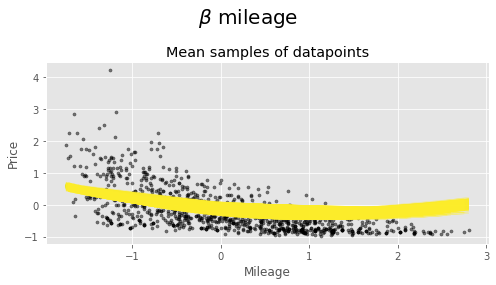

In [151]:
fig, axes = plt.subplots(1,1, figsize=(7, 4),sharey=True,sharex=True) 
for i in range(459):
    axes.plot(d_short.s_mileage,
              alpha_fit[i]+beta_mileage_fit[i][0]*d_short.s_mileage+beta_mileage_fit[i][1]*d_short.s_mileage2,
              color=MID,
              alpha=0.5,
              linewidth=0.5)
axes.scatter(d_short.s_mileage,d_short.s_price,color='black',alpha=0.5,s=10)
axes.set_title('Mean samples of datapoints'.format(len(d_short)))
fig.suptitle(r'$\beta$ mileage', fontsize=20)
axes.set_ylabel('Price')
axes.set_xlabel('Mileage')
fig.tight_layout()
plt.show()

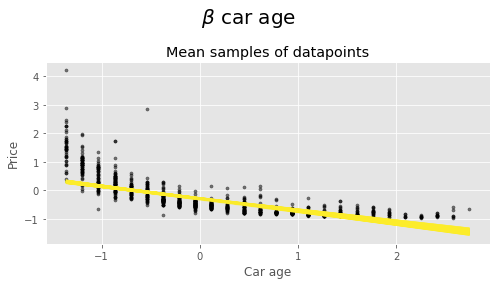

In [143]:
fig, axes = plt.subplots(1,1, figsize=(7, 4),sharey=True,sharex=True) 
for i in range(459):
    axes.plot(d_short.s_car_age,
              alpha_fit[i]-beta_car_age_fit[i]*d_short.s_car_age,
              color=MID,
              alpha=0.5,
              linewidth=0.5)
axes.scatter(d_short.s_car_age,d_short.s_price,color='black',alpha=0.5,s=10)
axes.set_title('Mean samples of datapoints'.format(len(d_short)))
fig.suptitle(r'$\beta$ car age', fontsize=20)
axes.set_ylabel('Price')
axes.set_xlabel('Car age')
fig.tight_layout()
plt.show()
# beta for BMI parameter is very close to 0 and insignificant

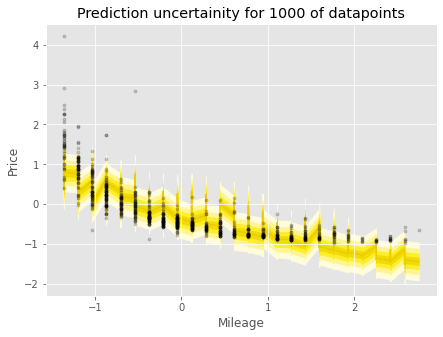

In [144]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
axes = ribbon_plot(d_short.s_car_age.values, price_pred_2, axes, supress_warning=True) 
axes.scatter(d_short.s_car_age, d_short.s_price, color='black', alpha=0.2,s=10) 
axes.set_xlabel('Mileage')
axes.set_ylabel('Price')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(d_short))) 
plt.show()

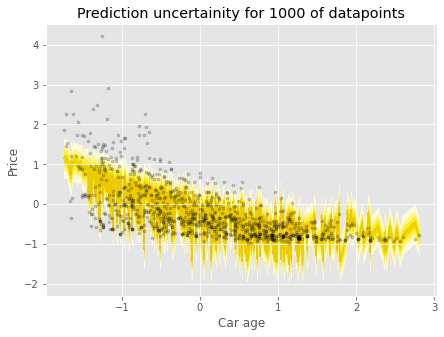

In [145]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))
axes = ribbon_plot(d_short.s_mileage.values, price_pred_2, axes, supress_warning=True) 
axes.scatter(d_short.s_mileage, d_short.s_price, color='black', alpha=0.2,s=10) 
axes.set_xlabel('Car age')
axes.set_ylabel('Price')
axes.set_title('Prediction uncertainity for {} of datapoints'.format(len(d_short))) 
plt.show()

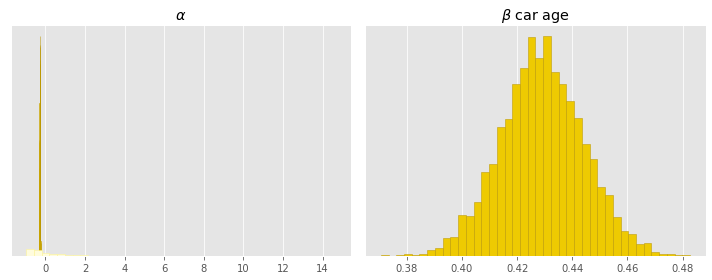

In [146]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0] 
ax.hist(alpha_fit,bins=40,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True) 
ax.hist(data.s_price,bins=40,color=LIGHT,edgecolor=LIGHT_HIGHLIGHT,density=True) 
ax.set_title(r'$\alpha$')
ax.set_yticks(())

fig.tight_layout()
ax2 = axes[1] 
ax2.hist(beta_car_age_fit,bins=40,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True) 
ax2.set_title(r'$\beta$ car age')
ax2.set_yticks(())
fig.tight_layout()
plt.show()

Comparing models

In [147]:
# Comparing 2 models: model_1 - with mielage only, model_2 - with mielage and car age
idata1 = az.from_cmdstanpy(posterior = fit1, log_likelihood = "log_lik")
idata2 = az.from_cmdstanpy(posterior = fit2, log_likelihood = "log_lik") 
compare_dict = {"model_1": idata1, "model_2": idata2}
az.compare(compare_dict, ic = "loo") # loo stands for leave one out cross validation

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_2,0,-432.523087,10.838371,0.000000,0.99951,56.671604,0.000000,False,log
model_1,1,-767.602296,5.520714,335.079208,0.00049,39.999481,23.662643,False,log


In [148]:
# Comparing 2 models: model_1 - with mielage only, model_2 - with mielage and car age
idata1 = az.from_cmdstanpy(posterior = fit1, log_likelihood = "log_lik")
idata2 = az.from_cmdstanpy(posterior = fit2, log_likelihood = "log_lik") 
compare_dict = {"model_1": idata1, "model_2": idata2}
az.compare(compare_dict, ic = "waic") # loo stands for leave one out cross validation

/usr/local/anaconda3/envs/DataAnalytics/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/anaconda3/envs/DataAnalytics/lib/python3.8/site-packages/arviz/stats/stats.py:1458: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_2,0,-432.543730,10.859013,0.000000,0.99951,56.685715,0.000000,True,log
model_1,1,-767.601506,5.519924,335.057776,0.00049,39.998592,23.675999,True,log


<AxesSubplot:xlabel='Log'>

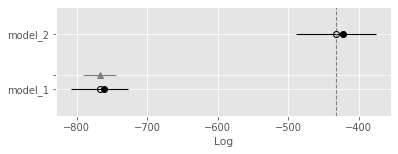

In [149]:
az.plot_compare(az.compare(compare_dict))
